<div class="alert alert-block alert-info">
<h1>Missing value imputation with Python : <code>3-missing_value_imputation.ipynb</code></h1>
</div>

---

### The purpose of this notebook is to use different methods to fill the missing values in our peak table :

These methods come from the scikitlearn documentation : [cf. doc scikitlearn](https://scikit-learn.org/stable/modules/impute.html#marking-imputed-values)

One type of imputation algorithm is __univariate__, which imputes values in the i-th feature dimension __using only non-missing values in that feature dimension__ (e.g. <code>impute.SimpleImputer</code>). By contrast, __multivariate__ imputation algorithms __use the entire set of available feature dimensions__ to estimate the missing values (e.g. <code>impute.IterativeImputer</code>).

---
# Table of contents
- [0 - Import modules](#0---Import-modules)
- [0 - Import useful functions](#0---Import-useful-functions)
- [0 - Import peak table](#0---Import-peak-table)
  - [a - Keep only intensities in the following dataframe](#a---Keep-only-intensities-in-the-following-dataframe)
  - [b - Keep only metadata in the following dataframe](#b---Keep-only-metadata-in-the-following-dataframe)
- [1 - Plot missing values](#1---Plot-missing-values)
- [2 - Set missing values to NaNs](#2---Set-missing-values-to-NaNs)
- [3 - Path to save imputed peak tables](#3---Path-to-save-imputed-peak-tables)
- [4 - Univariate feature imputation](#4---Univariate-feature-imputation)
  - [a - Constant imputation (with whatever constant value passed as argument)](#a---Constant-imputation-(with-whatever-constant-value-passed-as-argument))
  - [b - mean imputation](#b---mean-imputation)
  - [c - median imputation](#c---median-imputation)
  - [d - mode imputation (most frequent)](#d---mode-imputation-(most-frequent))
  - [e - minimum value of the feature (column)](#e---minimum-value-of-the-feature-(column))
  - [f - half minimum value of the feature (column)](#f---half-minimum-value-of-the-feature-(column))
- [5 - Multivariate feature imputation](#5---Multivariate-feature-imputation)
- [6 - Nearest neighbors imputation](#6---Nearest-neighbors-imputation)
- [7 - Choose best imputation method](#7---Choose-best-imputation-method)
- [8 - Select peak table with most adapated method for further analysis and save it](#8---Select-peak-table-with-most-adapated-method-for-further-analysis-and-save-it)
---

# 0 - Import modules

In [1]:
import pandas as pd
import seaborn as sns
import sklearn
import os

In [2]:
# Setting working directory
import re
pwd = ! pwd
pwd = re.sub('notebooks/', '', pwd[0])
pwd = '/'.join(pwd.split('/')[:-1]) + '/'
print(f'Working directory : {pwd}')

# Print Python version
python_version = ! python --version
print(f'Python version : {python_version[0]}')

Working directory : /home/jovyan/work/
Python version : Python 3.10.4


In [3]:
# Tune the visual settings for figures in seaborn
sns.set_context(
    "notebook", font_scale=1.2, rc={"figure.figsize": (15,8), "axes.titlesize": 15}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 15, 8

sns.set_theme(style="darkgrid")

# 0 - Import useful functions

In [4]:
# In the bin folder, python scripts containing useful functions can be found.
# Functions for data exploration are located in file missing_value_imputation_functions.py

import sys
sys.path.append(pwd + 'bin/')

from explore_data_functions import *
from missing_value_imputation_functions import *

# 0 - Import peak table

#### Here we can choose to impute either the whole peak table or the one with strongly correlated features removed

In [5]:
# We store the imported peak table and set a copy in an other dataframe
# We can have access to the initial peak table any time
# Hint : It is always better to manipulate a copy than the original dataframe

# peakTable_imported = pd.read_csv(pwd + 'data/synthetic_dataset/synthetic_dataset.csv')
# or
peakTable_imported = pd.read_csv(pwd + 'data/synthetic_dataset/synthetic_dataset_remove_corr.csv')
peakTable = peakTable_imported.copy()
peakTable

,SampleID,Disease,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,CRR_001,CRR,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,...,23332.588540,345.695685,0.000000,0.000000,0.000000,5.194313,166.610410,77.783406,8.630945,62.252431
1,CRR_002,CRR,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,...,19571.422043,242.840315,1.981778,0.000000,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,CRR_003,CRR,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,CRR_004,CRR,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,CRR_005,CRR,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,HCC_296,HCC,1307.377728,187.166724,330.124145,1100.770379,610.444945,731.605822,783.995362,804.098475,...,473.805391,354.091994,246.883160,176.488767,175.813061,331.700933,787.599359,19.945047,456.842307,55.751046
596,HCC_297,HCC,714.674697,88.631286,295.155447,217.305148,369.804011,252.653913,216.791172,462.004967,...,1839.941207,519.450121,114.346408,83.062311,89.827003,309.682566,348.038788,83.925800,365.545100,46.222988
597,HCC_298,HCC,1034.242121,699.345217,380.957087,604.125654,431.331251,309.331561,460.046415,887.358755,...,149.149811,703.127195,371.898553,286.148673,261.366945,351.607766,514.511997,111.443139,1045.644800,97.461422
598,HCC_299,HCC,870.037466,28.948919,177.750685,323.497432,299.576371,459.865707,405.623088,333.229357,...,822.090326,388.178444,44.474945,50.019532,62.189603,467.290703,181.126309,13.391195,410.875464,33.517221


In [6]:
peakTable.shape

(600, 589)

The peak table contains 600 rows (samples), 1588 columns (2 for metadata and 1586 compounds) for the original peak table, and 620 columns in the peak table with correlated features removed.

## a - Keep only intensities in the following dataframe

In [7]:
intensities = peakTable.iloc[:, ['variable' in col for col in peakTable.columns]]
intensities.head()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,109.607280,1474.590504,...,23332.588540,345.695685,0.000000,0.000000,0.000000,5.194313,166.610410,77.783406,8.630945,62.252431
1,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,92.467096,1443.736018,...,19571.422043,242.840315,1.981778,0.000000,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,459.127995,1424.382600,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,389.919091,1537.402022,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,485.004097,452.314008,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103


In [8]:
intensities.shape

(600, 587)

## b - Keep only metadata in the following dataframe

In [9]:
metadata = peakTable.drop(intensities.columns, axis=1)
metadata

,SampleID,Disease
0,CRR_001,CRR
1,CRR_002,CRR
2,CRR_003,CRR
3,CRR_004,CRR
4,CRR_005,CRR
...,...,...
595,HCC_296,HCC
596,HCC_297,HCC
597,HCC_298,HCC
598,HCC_299,HCC


In [10]:
metadata.shape

(600, 2)

# 1 - Plot missing values

######################################################################################################################################################
Considering 0 as missing values :
- Total number of missing values : 1630
- Percent of missing values : 0.46%



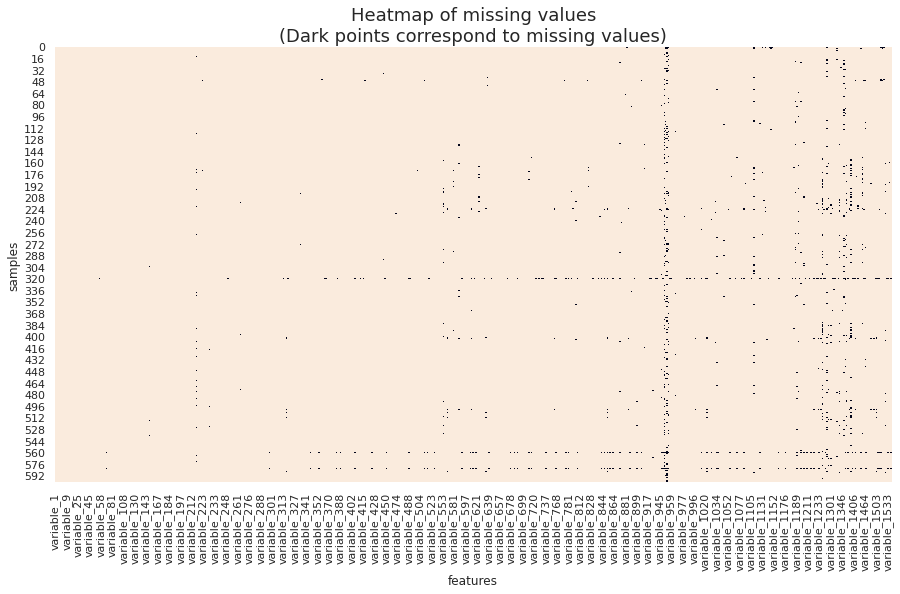

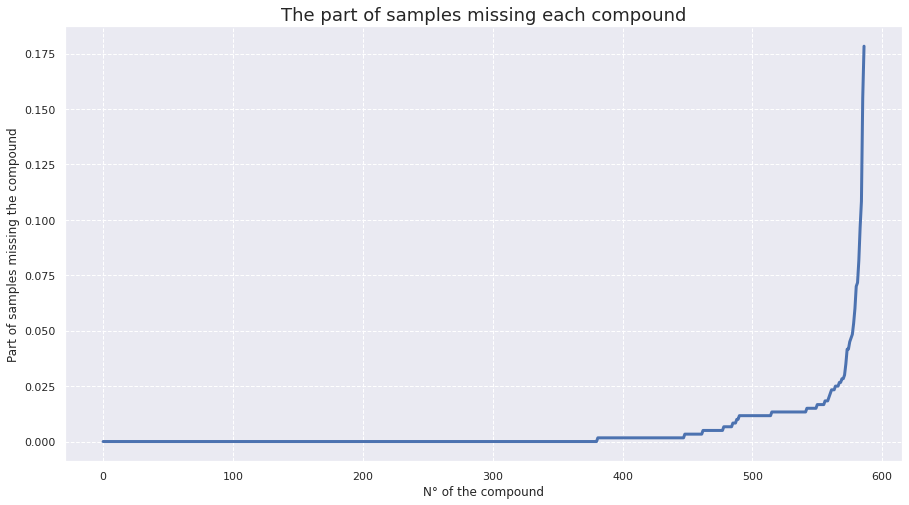



######################################################################################################################################################


In [11]:
# In our data, missing values are set to 0
plot_infos_missing_values(intensities, na_values=0)

# 2 - Set missing values to NaNs

<div class="alert alert-block alert-success">
    <h3>
        If missing values of the initial peak table are not NaNs, we have to convert it.<br>
        In this peak table for example, missing values are 0's, but we need NaNs for missing value imputation methods.
    </h3>
</div>

In [12]:
# Our peak table has no NaNs 
intensities.isna().sum().sum()

0

In [13]:
# The missing values are 0
(intensities == 0).sum().sum()

1630

In [14]:
# Call function set_missing_value_to_Nan to replace initial missing values to NaNs
# returned dataframe has now numpy NaNs
intensities_NaNs = set_missing_value_to_Nan(intensities, na_values=0)
intensities_NaNs.isna().sum().sum()

1630

In [15]:
intensities_NaNs

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,109.607280,1474.590504,...,23332.588540,345.695685,NaN,NaN,NaN,5.194313,166.610410,77.783406,8.630945,62.252431
1,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,92.467096,1443.736018,...,19571.422043,242.840315,1.981778,NaN,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,459.127995,1424.382600,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,389.919091,1537.402022,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,485.004097,452.314008,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1307.377728,187.166724,330.124145,1100.770379,610.444945,731.605822,783.995362,804.098475,98.863618,284.142056,...,473.805391,354.091994,246.883160,176.488767,175.813061,331.700933,787.599359,19.945047,456.842307,55.751046
596,714.674697,88.631286,295.155447,217.305148,369.804011,252.653913,216.791172,462.004967,291.308280,49.491236,...,1839.941207,519.450121,114.346408,83.062311,89.827003,309.682566,348.038788,83.925800,365.545100,46.222988
597,1034.242121,699.345217,380.957087,604.125654,431.331251,309.331561,460.046415,887.358755,278.464080,1454.364558,...,149.149811,703.127195,371.898553,286.148673,261.366945,351.607766,514.511997,111.443139,1045.644800,97.461422
598,870.037466,28.948919,177.750685,323.497432,299.576371,459.865707,405.623088,333.229357,182.355646,56.180547,...,822.090326,388.178444,44.474945,50.019532,62.189603,467.290703,181.126309,13.391195,410.875464,33.517221


# 3 - Path to save imputed peak tables

In [16]:
path_peakTable_imputed = pwd + 'data/synthetic_dataset/imputed_peak_tables/'

if os.path.exists(path_peakTable_imputed):
    print(f'Directory {path_peakTable_imputed} already exists !')
else:
    os.makedirs(path_peakTable_imputed)
    print(f'Directory {path_peakTable_imputed} created !')

Directory /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/ already exists !


# 4 - Univariate feature imputation

## a - Constant imputation (with whatever constant value passed as argument)

All missing values in the peak table will be replaced by the constant value passed as argument.

In [17]:
# const_imputer default inputs missing values with 0
intensities_const_0 = const_imputer(intensities_NaNs)
display(intensities_const_0)
filename = 'intensities_const_0.csv'
intensities_const_0.to_csv(path_peakTable_imputed + filename, index = False, header=True)
print(f'Imputed peak table {filename} saved in {path_peakTable_imputed}')

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,109.607280,1474.590504,...,23332.588540,345.695685,0.000000,0.000000,0.000000,5.194313,166.610410,77.783406,8.630945,62.252431
1,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,92.467096,1443.736018,...,19571.422043,242.840315,1.981778,0.000000,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,459.127995,1424.382600,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,389.919091,1537.402022,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,485.004097,452.314008,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1307.377728,187.166724,330.124145,1100.770379,610.444945,731.605822,783.995362,804.098475,98.863618,284.142056,...,473.805391,354.091994,246.883160,176.488767,175.813061,331.700933,787.599359,19.945047,456.842307,55.751046
596,714.674697,88.631286,295.155447,217.305148,369.804011,252.653913,216.791172,462.004967,291.308280,49.491236,...,1839.941207,519.450121,114.346408,83.062311,89.827003,309.682566,348.038788,83.925800,365.545100,46.222988
597,1034.242121,699.345217,380.957087,604.125654,431.331251,309.331561,460.046415,887.358755,278.464080,1454.364558,...,149.149811,703.127195,371.898553,286.148673,261.366945,351.607766,514.511997,111.443139,1045.644800,97.461422
598,870.037466,28.948919,177.750685,323.497432,299.576371,459.865707,405.623088,333.229357,182.355646,56.180547,...,822.090326,388.178444,44.474945,50.019532,62.189603,467.290703,181.126309,13.391195,410.875464,33.517221


Imputed peak table intensities_const_0.csv saved in /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/


In [18]:
# Input with 1
intensities_const_1 = const_imputer(intensities_NaNs, 1)
display(intensities_const_1)
filename = 'intensities_const_1.csv'
intensities_const_1.to_csv(path_peakTable_imputed + filename, index = False, header=True)
print(f'Imputed peak table {filename} saved in {path_peakTable_imputed}')

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,109.607280,1474.590504,...,23332.588540,345.695685,1.000000,1.000000,1.000000,5.194313,166.610410,77.783406,8.630945,62.252431
1,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,92.467096,1443.736018,...,19571.422043,242.840315,1.981778,1.000000,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,459.127995,1424.382600,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,389.919091,1537.402022,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,485.004097,452.314008,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1307.377728,187.166724,330.124145,1100.770379,610.444945,731.605822,783.995362,804.098475,98.863618,284.142056,...,473.805391,354.091994,246.883160,176.488767,175.813061,331.700933,787.599359,19.945047,456.842307,55.751046
596,714.674697,88.631286,295.155447,217.305148,369.804011,252.653913,216.791172,462.004967,291.308280,49.491236,...,1839.941207,519.450121,114.346408,83.062311,89.827003,309.682566,348.038788,83.925800,365.545100,46.222988
597,1034.242121,699.345217,380.957087,604.125654,431.331251,309.331561,460.046415,887.358755,278.464080,1454.364558,...,149.149811,703.127195,371.898553,286.148673,261.366945,351.607766,514.511997,111.443139,1045.644800,97.461422
598,870.037466,28.948919,177.750685,323.497432,299.576371,459.865707,405.623088,333.229357,182.355646,56.180547,...,822.090326,388.178444,44.474945,50.019532,62.189603,467.290703,181.126309,13.391195,410.875464,33.517221


Imputed peak table intensities_const_1.csv saved in /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/


## b - mean imputation

For each feature, the missing values are imputed by the mean value of the non-missing values in that feature (column).

In [19]:
intensities_mean = mean_imputer(intensities_NaNs)
display(intensities_mean)
filename = 'intensities_mean.csv'
intensities_mean.to_csv(path_peakTable_imputed + filename, index = False, header=True)
print(f'Imputed peak table {filename} saved in {path_peakTable_imputed}')

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,109.607280,1474.590504,...,23332.588540,345.695685,182.949392,131.311102,128.301098,5.194313,166.610410,77.783406,8.630945,62.252431
1,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,92.467096,1443.736018,...,19571.422043,242.840315,1.981778,131.311102,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,459.127995,1424.382600,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,389.919091,1537.402022,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,485.004097,452.314008,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1307.377728,187.166724,330.124145,1100.770379,610.444945,731.605822,783.995362,804.098475,98.863618,284.142056,...,473.805391,354.091994,246.883160,176.488767,175.813061,331.700933,787.599359,19.945047,456.842307,55.751046
596,714.674697,88.631286,295.155447,217.305148,369.804011,252.653913,216.791172,462.004967,291.308280,49.491236,...,1839.941207,519.450121,114.346408,83.062311,89.827003,309.682566,348.038788,83.925800,365.545100,46.222988
597,1034.242121,699.345217,380.957087,604.125654,431.331251,309.331561,460.046415,887.358755,278.464080,1454.364558,...,149.149811,703.127195,371.898553,286.148673,261.366945,351.607766,514.511997,111.443139,1045.644800,97.461422
598,870.037466,28.948919,177.750685,323.497432,299.576371,459.865707,405.623088,333.229357,182.355646,56.180547,...,822.090326,388.178444,44.474945,50.019532,62.189603,467.290703,181.126309,13.391195,410.875464,33.517221


Imputed peak table intensities_mean.csv saved in /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/


## c - median imputation

For each feature, the missing values are imputed by the median value of the non-missing values in that feature (column).

In [20]:
intensities_median = median_imputer(intensities_NaNs)
display(intensities_median)
filename = 'intensities_median.csv'
intensities_median.to_csv(path_peakTable_imputed + filename, index = False, header=True)
print(f'Imputed peak table {filename} saved in {path_peakTable_imputed}')

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,109.607280,1474.590504,...,23332.588540,345.695685,185.885694,131.258194,129.730059,5.194313,166.610410,77.783406,8.630945,62.252431
1,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,92.467096,1443.736018,...,19571.422043,242.840315,1.981778,131.258194,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,459.127995,1424.382600,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,389.919091,1537.402022,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,485.004097,452.314008,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1307.377728,187.166724,330.124145,1100.770379,610.444945,731.605822,783.995362,804.098475,98.863618,284.142056,...,473.805391,354.091994,246.883160,176.488767,175.813061,331.700933,787.599359,19.945047,456.842307,55.751046
596,714.674697,88.631286,295.155447,217.305148,369.804011,252.653913,216.791172,462.004967,291.308280,49.491236,...,1839.941207,519.450121,114.346408,83.062311,89.827003,309.682566,348.038788,83.925800,365.545100,46.222988
597,1034.242121,699.345217,380.957087,604.125654,431.331251,309.331561,460.046415,887.358755,278.464080,1454.364558,...,149.149811,703.127195,371.898553,286.148673,261.366945,351.607766,514.511997,111.443139,1045.644800,97.461422
598,870.037466,28.948919,177.750685,323.497432,299.576371,459.865707,405.623088,333.229357,182.355646,56.180547,...,822.090326,388.178444,44.474945,50.019532,62.189603,467.290703,181.126309,13.391195,410.875464,33.517221


Imputed peak table intensities_median.csv saved in /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/


## d - mode imputation (most frequent)

For each feature, the missing values are imputed by the most frequent value (rounded at 1.e-2) of the non-missing values in that feature (column).

In [21]:
intensities_mode = mode_imputer(intensities_NaNs)
display(intensities_mode)
filename = 'intensities_mode.csv'
intensities_mode.to_csv(path_peakTable_imputed + filename, index = False, header=True)
print(f'Imputed peak table {filename} saved in {path_peakTable_imputed}')

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,109.607280,1474.590504,...,23332.588540,345.695685,182.930000,119.000000,1.270000,5.194313,166.610410,77.783406,8.630945,62.252431
1,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,92.467096,1443.736018,...,19571.422043,242.840315,1.981778,119.000000,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,459.127995,1424.382600,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,389.919091,1537.402022,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,485.004097,452.314008,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1307.377728,187.166724,330.124145,1100.770379,610.444945,731.605822,783.995362,804.098475,98.863618,284.142056,...,473.805391,354.091994,246.883160,176.488767,175.813061,331.700933,787.599359,19.945047,456.842307,55.751046
596,714.674697,88.631286,295.155447,217.305148,369.804011,252.653913,216.791172,462.004967,291.308280,49.491236,...,1839.941207,519.450121,114.346408,83.062311,89.827003,309.682566,348.038788,83.925800,365.545100,46.222988
597,1034.242121,699.345217,380.957087,604.125654,431.331251,309.331561,460.046415,887.358755,278.464080,1454.364558,...,149.149811,703.127195,371.898553,286.148673,261.366945,351.607766,514.511997,111.443139,1045.644800,97.461422
598,870.037466,28.948919,177.750685,323.497432,299.576371,459.865707,405.623088,333.229357,182.355646,56.180547,...,822.090326,388.178444,44.474945,50.019532,62.189603,467.290703,181.126309,13.391195,410.875464,33.517221


Imputed peak table intensities_mode.csv saved in /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/


## e - minimum value of the feature (column)

For each feature, the missing values are imputed by the minimum value of the non-missing values in that feature (column).

In [22]:
intensities_min = min_imputer(intensities_NaNs)
display(intensities_min)
filename = 'intensities_min.csv'
intensities_min.to_csv(path_peakTable_imputed + filename, index = False, header=True)
print(f'Imputed peak table {filename} saved in {path_peakTable_imputed}')

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,109.607280,1474.590504,...,23332.588540,345.695685,0.674491,0.660889,0.674491,5.194313,166.610410,77.783406,8.630945,62.252431
1,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,92.467096,1443.736018,...,19571.422043,242.840315,1.981778,0.660889,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,459.127995,1424.382600,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,389.919091,1537.402022,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,485.004097,452.314008,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1307.377728,187.166724,330.124145,1100.770379,610.444945,731.605822,783.995362,804.098475,98.863618,284.142056,...,473.805391,354.091994,246.883160,176.488767,175.813061,331.700933,787.599359,19.945047,456.842307,55.751046
596,714.674697,88.631286,295.155447,217.305148,369.804011,252.653913,216.791172,462.004967,291.308280,49.491236,...,1839.941207,519.450121,114.346408,83.062311,89.827003,309.682566,348.038788,83.925800,365.545100,46.222988
597,1034.242121,699.345217,380.957087,604.125654,431.331251,309.331561,460.046415,887.358755,278.464080,1454.364558,...,149.149811,703.127195,371.898553,286.148673,261.366945,351.607766,514.511997,111.443139,1045.644800,97.461422
598,870.037466,28.948919,177.750685,323.497432,299.576371,459.865707,405.623088,333.229357,182.355646,56.180547,...,822.090326,388.178444,44.474945,50.019532,62.189603,467.290703,181.126309,13.391195,410.875464,33.517221


Imputed peak table intensities_min.csv saved in /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/


## f - half minimum value of the feature (column)

For each feature, the missing values are imputed by the half of the minimum value of the non-missing values in that feature.

In [23]:
intensities_half_min = half_min_imputer(intensities_NaNs)
display(intensities_half_min)
filename = 'intensities_half_min.csv'
intensities_half_min.to_csv(path_peakTable_imputed + filename, index = False, header=True)
print(f'Imputed peak table {filename} saved in {path_peakTable_imputed}')

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,109.607280,1474.590504,...,23332.588540,345.695685,0.337245,0.330444,0.337245,5.194313,166.610410,77.783406,8.630945,62.252431
1,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,92.467096,1443.736018,...,19571.422043,242.840315,1.981778,0.330444,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,459.127995,1424.382600,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,389.919091,1537.402022,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,485.004097,452.314008,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1307.377728,187.166724,330.124145,1100.770379,610.444945,731.605822,783.995362,804.098475,98.863618,284.142056,...,473.805391,354.091994,246.883160,176.488767,175.813061,331.700933,787.599359,19.945047,456.842307,55.751046
596,714.674697,88.631286,295.155447,217.305148,369.804011,252.653913,216.791172,462.004967,291.308280,49.491236,...,1839.941207,519.450121,114.346408,83.062311,89.827003,309.682566,348.038788,83.925800,365.545100,46.222988
597,1034.242121,699.345217,380.957087,604.125654,431.331251,309.331561,460.046415,887.358755,278.464080,1454.364558,...,149.149811,703.127195,371.898553,286.148673,261.366945,351.607766,514.511997,111.443139,1045.644800,97.461422
598,870.037466,28.948919,177.750685,323.497432,299.576371,459.865707,405.623088,333.229357,182.355646,56.180547,...,822.090326,388.178444,44.474945,50.019532,62.189603,467.290703,181.126309,13.391195,410.875464,33.517221


Imputed peak table intensities_half_min.csv saved in /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/


# 5 - Multivariate feature imputation

[cf. doc scikitlearn IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer)

<code>IterativeImputer</code> was inspired by the R MICE package (Multivariate Imputation by Chained Equations).

On this page ([link](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html)) are presented the different possible estimators that can be applied with <code>IterativeImputer</code> :
- <code>BayesianRidge</code> : regularized linear regression
- <code>DecisionTreeRegressor</code> : non-linear regression
- <code>ExtraTreesRegressor</code> : similar to missForest in R
- <code>KNeighborsRegressor</code> : comparable to other KNN imputation approaches


In [24]:
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

In [25]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]

In [26]:
for estimator in estimators:
    
    print(f"- {str(estimator).split('(')[0]} :")
    intensities_python_MICE = python_MICE_imputer(intensities_NaNs, estimator)
    filename = 'intensities_python_MICE_' + str(estimator).split('(')[0] + '.csv'
    intensities_python_MICE.to_csv(path_peakTable_imputed + filename, index = False, header=True)
    print(f'Imputed peak table {filename} saved in {path_peakTable_imputed}\n')

- BayesianRidge :


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 6.7 seconds -----
Imputed peak table intensities_python_MICE_BayesianRidge.csv saved in /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/

- DecisionTreeRegressor :


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 14.6 seconds -----
Imputed peak table intensities_python_MICE_DecisionTreeRegressor.csv saved in /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/

- ExtraTreesRegressor :


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 88.9 seconds -----
Imputed peak table intensities_python_MICE_ExtraTreesRegressor.csv saved in /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/

- KNeighborsRegressor :


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 5.4 seconds -----
Imputed peak table intensities_python_MICE_KNeighborsRegressor.csv saved in /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/



# 6 - Nearest neighbors imputation

According to scikit-learn documentation (https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation), "Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. If a sample has more than one feature missing, then the neighbors for that sample can be different depending on the particular feature being imputed."

We let the possibility for the user to impute the values along the two axis with the parameter 'by' :
- by='samples' (default) : the missing value for a specific feature in a sample is imputed using the values of that feature in the n_neighbors samples which have a non-missing value for that feature
- by='feature' : the missing value for a specific feature in a sample is imputed using the values of the n_neighbors features in that sample which have a non-missing value for that sample

## a - features as neighbours

In [27]:
intensities_KNN_features = KNN_imputer(intensities_NaNs, by='features')
display(intensities_KNN_features)
filename = 'intensities_KNN_features.csv'
intensities_KNN_features.to_csv(path_peakTable_imputed + filename, index = False, header=True)
print(f'Imputed peak table {filename} saved in {path_peakTable_imputed}')

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,109.607280,1474.590504,...,23332.588540,345.695685,62.846456,123.399713,123.399713,5.194313,166.610410,77.783406,8.630945,62.252431
1,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,92.467096,1443.736018,...,19571.422043,242.840315,1.981778,77.181777,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,459.127995,1424.382600,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,389.919091,1537.402022,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,485.004097,452.314008,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1307.377728,187.166724,330.124145,1100.770379,610.444945,731.605822,783.995362,804.098475,98.863618,284.142056,...,473.805391,354.091994,246.883160,176.488767,175.813061,331.700933,787.599359,19.945047,456.842307,55.751046
596,714.674697,88.631286,295.155447,217.305148,369.804011,252.653913,216.791172,462.004967,291.308280,49.491236,...,1839.941207,519.450121,114.346408,83.062311,89.827003,309.682566,348.038788,83.925800,365.545100,46.222988
597,1034.242121,699.345217,380.957087,604.125654,431.331251,309.331561,460.046415,887.358755,278.464080,1454.364558,...,149.149811,703.127195,371.898553,286.148673,261.366945,351.607766,514.511997,111.443139,1045.644800,97.461422
598,870.037466,28.948919,177.750685,323.497432,299.576371,459.865707,405.623088,333.229357,182.355646,56.180547,...,822.090326,388.178444,44.474945,50.019532,62.189603,467.290703,181.126309,13.391195,410.875464,33.517221


Imputed peak table intensities_KNN_features.csv saved in /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/


## b - samples as neighbours

In [28]:
intensities_KNN_samples = KNN_imputer(intensities_NaNs, by='samples')
display(intensities_KNN_samples)
filename = 'intensities_KNN_samples.csv'
intensities_KNN_samples.to_csv(path_peakTable_imputed + filename, index = False, header=True)
print(f'Imputed peak table {filename} saved in {path_peakTable_imputed}')

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,109.607280,1474.590504,...,23332.588540,345.695685,20.878982,11.653312,10.339822,5.194313,166.610410,77.783406,8.630945,62.252431
1,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,92.467096,1443.736018,...,19571.422043,242.840315,1.981778,106.369337,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,459.127995,1424.382600,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,389.919091,1537.402022,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,485.004097,452.314008,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1307.377728,187.166724,330.124145,1100.770379,610.444945,731.605822,783.995362,804.098475,98.863618,284.142056,...,473.805391,354.091994,246.883160,176.488767,175.813061,331.700933,787.599359,19.945047,456.842307,55.751046
596,714.674697,88.631286,295.155447,217.305148,369.804011,252.653913,216.791172,462.004967,291.308280,49.491236,...,1839.941207,519.450121,114.346408,83.062311,89.827003,309.682566,348.038788,83.925800,365.545100,46.222988
597,1034.242121,699.345217,380.957087,604.125654,431.331251,309.331561,460.046415,887.358755,278.464080,1454.364558,...,149.149811,703.127195,371.898553,286.148673,261.366945,351.607766,514.511997,111.443139,1045.644800,97.461422
598,870.037466,28.948919,177.750685,323.497432,299.576371,459.865707,405.623088,333.229357,182.355646,56.180547,...,822.090326,388.178444,44.474945,50.019532,62.189603,467.290703,181.126309,13.391195,410.875464,33.517221


Imputed peak table intensities_KNN_samples.csv saved in /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/


# 7 - Choose best imputation method

Function <code>choose_best_imputation_method</code> determines the most adapted imputation method for the intensities peak table passed as argument.

For all peak tables imputed above in the notebook, we randomly remove values, re-impute them with different methods and compute the RMSE. The method with the minimum value of RMSE is considered the most adapted to the peak table.

3 arguments has to be given to the function :
- X : peak table with only feature values (no metadata)
- path_peakTable_imputed : path to save imputed peak tables
- number_iterations (default=1) : number of times we compute the imputation (to decrease imputation variability for some methods)

The output is a dataframe of ranked imputation methods (in decreasing order of RMSE).

In [29]:
df_RMSE = choose_best_imputation_method(intensities_NaNs, path_peakTable_imputed, number_iterations=3)

######################################################################################################################################################
################################################################## Start processing ##################################################################
###################################################################################################################################################### 

--> Inputed dataframe has shape : (600, 587)

--> List of used imputation methods : ['KNN_features', 'KNN_samples', 'const_0', 'const_1', 'half_min', 'mean', 'median', 'min', 'mode', 'python_MICE_BayesianRidge', 'python_MICE_DecisionTreeRegressor', 'python_MICE_ExtraTreesRegressor', 'python_MICE_KNeighborsRegressor']

--> Rate of NaNs in the inputed peak table : 0.46%

------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------

/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 4.1 seconds -----

Processing : python_MICE_DecisionTreeRegressor..........


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 7.8 seconds -----

Processing : python_MICE_ExtraTreesRegressor..........


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 61.2 seconds -----

Processing : python_MICE_KNeighborsRegressor..........


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 5.3 seconds -----


--> After iteration 1, dict_RMSE updated
------------------------------------------------------------------------------------------------------------------------------------------------------



------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------- Iteration 2 -------------------------------------------------------------------
--> Subset dataframe has shape : (600, 381)

Processing : KNN_features..........

Processing : KNN_samples..........

Processing : const_0..........

Processing : const_1..........

Processing : half_min..........

Processing : mean..........

Processing : median..........

Processing : min..........

Processing : mode..........

Processing : python_MICE_BayesianRidge..........


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 4.4 seconds -----

Processing : python_MICE_DecisionTreeRegressor..........


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 8.1 seconds -----

Processing : python_MICE_ExtraTreesRegressor..........


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 61.2 seconds -----

Processing : python_MICE_KNeighborsRegressor..........


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 5.2 seconds -----


--> After iteration 2, dict_RMSE updated
------------------------------------------------------------------------------------------------------------------------------------------------------



------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------- Iteration 3 -------------------------------------------------------------------
--> Subset dataframe has shape : (600, 381)

Processing : KNN_features..........

Processing : KNN_samples..........

Processing : const_0..........

Processing : const_1..........

Processing : half_min..........

Processing : mean..........

Processing : median..........

Processing : min..........

Processing : mode..........

Processing : python_MICE_BayesianRidge..........


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 4.3 seconds -----

Processing : python_MICE_DecisionTreeRegressor..........


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 8.0 seconds -----

Processing : python_MICE_ExtraTreesRegressor..........


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 62.7 seconds -----

Processing : python_MICE_KNeighborsRegressor..........


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 5.9 seconds -----


--> After iteration 3, dict_RMSE updated
------------------------------------------------------------------------------------------------------------------------------------------------------



{'KNN_features': 737902.5186492419, 'KNN_samples': 26773.465070302278, 'const_0': 1205439.3316095355, 'const_1': 1205417.626762539, 'half_min': 1122149.2290338937, 'mean': 96988.18322094453, 'median': 100870.6184884148, 'min': 1043362.5911846993, 'mode': 730004.8800754339, 'python_MICE_BayesianRidge': 28703.241765086055, 'python_MICE_DecisionTreeRegressor': 23124.05428520168, 'python_MICE_ExtraTreesRegressor': 7291.822405682015, 'python_MICE_KNeighborsRegressor': 47217.39824843911}
######################################################################################################################################################


#### The most relevant method to impute missing values is the one with the smallest RMSE value.

#### ATTENTION : It is only true for the particular peak table passed as argument, the results can hugely vary for other examples !

In [30]:
df_RMSE

,Method,RMSE
0,const_0,1.205439e+06
1,const_1,1.205418e+06
2,half_min,1.122149e+06
3,min,1.043363e+06
4,KNN_features,7.379025e+05
5,mode,7.300049e+05
6,median,1.008706e+05
7,mean,9.698818e+04
8,python_MICE_KNeighborsRegressor,4.721740e+04
9,python_MICE_BayesianRidge,2.870324e+04


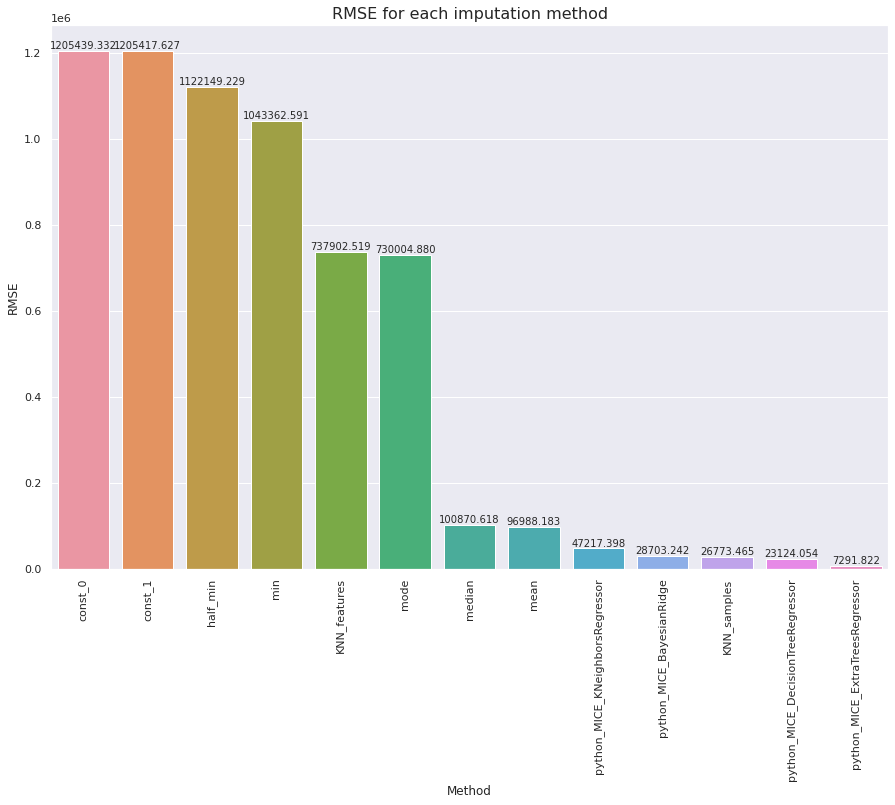

In [31]:
plot_RMSE_results(df_RMSE)

In [32]:
chosen_imputation_method = df_RMSE['Method'][len(df_RMSE)-1]
print(f'The most suitable method to impute missing data is : {chosen_imputation_method}')

The most suitable method to impute missing data is : python_MICE_ExtraTreesRegressor


# 8 - Select peak table with most adapated method for further analysis and save it

In [33]:
print(path_peakTable_imputed + 'intensities_' + chosen_imputation_method + '.csv')

/home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/intensities_python_MICE_ExtraTreesRegressor.csv


In [34]:
X_imputed = pd.read_csv(path_peakTable_imputed + 'intensities_' + chosen_imputation_method + '.csv', sep=',', decimal='.', na_values='NA')
X_imputed

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,109.607280,1474.590504,...,23332.588540,345.695685,2.631216,130.294107,19.170914,5.194313,166.610410,77.783406,8.630945,62.252431
1,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,92.467096,1443.736018,...,19571.422043,242.840315,1.981778,109.935021,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,459.127995,1424.382600,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,389.919091,1537.402022,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,485.004097,452.314008,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1307.377728,187.166724,330.124145,1100.770379,610.444945,731.605822,783.995362,804.098475,98.863618,284.142056,...,473.805391,354.091994,246.883160,176.488767,175.813061,331.700933,787.599359,19.945047,456.842307,55.751046
596,714.674697,88.631286,295.155447,217.305148,369.804011,252.653913,216.791172,462.004967,291.308280,49.491236,...,1839.941207,519.450121,114.346408,83.062311,89.827003,309.682566,348.038788,83.925800,365.545100,46.222988
597,1034.242121,699.345217,380.957087,604.125654,431.331251,309.331561,460.046415,887.358755,278.464080,1454.364558,...,149.149811,703.127195,371.898553,286.148673,261.366945,351.607766,514.511997,111.443139,1045.644800,97.461422
598,870.037466,28.948919,177.750685,323.497432,299.576371,459.865707,405.623088,333.229357,182.355646,56.180547,...,822.090326,388.178444,44.474945,50.019532,62.189603,467.290703,181.126309,13.391195,410.875464,33.517221


In [35]:
peakTable_imputed = pd.concat([metadata, X_imputed], axis=1)
peakTable_imputed

,SampleID,Disease,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,...,variable_1505,variable_1513,variable_1518,variable_1519,variable_1521,variable_1524,variable_1528,variable_1533,variable_1540,variable_1564
0,CRR_001,CRR,227.826520,117.012086,750.015310,106.848690,941.250268,28.308256,46.263365,1744.688754,...,23332.588540,345.695685,2.631216,130.294107,19.170914,5.194313,166.610410,77.783406,8.630945,62.252431
1,CRR_002,CRR,587.927618,129.710850,594.600666,145.488720,896.401881,27.842101,73.665886,1551.050083,...,19571.422043,242.840315,1.981778,109.935021,4.669376,112.927400,180.437923,53.271213,118.352041,73.772876
2,CRR_003,CRR,300.819627,208.803545,649.198550,99.151068,634.809418,7.656808,211.861276,1555.589994,...,3825.640322,1136.728114,301.778637,250.099082,190.029159,350.832313,293.545028,263.923145,356.792481,53.630690
3,CRR_004,CRR,574.124723,225.087555,586.409285,115.209639,628.911754,15.336427,94.711215,1643.625627,...,3900.435683,777.466659,312.186350,299.824366,266.307245,101.532018,338.136807,203.295067,188.081878,71.392762
4,CRR_005,CRR,235.369264,123.061042,638.782555,46.975815,724.054416,13.855861,85.444824,2163.577857,...,402.489171,1393.864687,202.706069,176.957407,158.474161,200.285709,769.535852,289.908010,515.551782,46.859103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,HCC_296,HCC,1307.377728,187.166724,330.124145,1100.770379,610.444945,731.605822,783.995362,804.098475,...,473.805391,354.091994,246.883160,176.488767,175.813061,331.700933,787.599359,19.945047,456.842307,55.751046
596,HCC_297,HCC,714.674697,88.631286,295.155447,217.305148,369.804011,252.653913,216.791172,462.004967,...,1839.941207,519.450121,114.346408,83.062311,89.827003,309.682566,348.038788,83.925800,365.545100,46.222988
597,HCC_298,HCC,1034.242121,699.345217,380.957087,604.125654,431.331251,309.331561,460.046415,887.358755,...,149.149811,703.127195,371.898553,286.148673,261.366945,351.607766,514.511997,111.443139,1045.644800,97.461422
598,HCC_299,HCC,870.037466,28.948919,177.750685,323.497432,299.576371,459.865707,405.623088,333.229357,...,822.090326,388.178444,44.474945,50.019532,62.189603,467.290703,181.126309,13.391195,410.875464,33.517221


### For the next notebook, the imputed peak table right above should be used ! We save it in a separate folder

In [36]:
path_peakTable_imputed_chosen = pwd + 'data/synthetic_dataset/imputed_peak_tables/chosen_imputed_peakTable/'

if os.path.exists(path_peakTable_imputed_chosen):
    print(f'Directory {path_peakTable_imputed_chosen} already exists !')
else:
    os.makedirs(path_peakTable_imputed_chosen)
    print(f'Directory {path_peakTable_imputed_chosen} created !')

Directory /home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/chosen_imputed_peakTable/ already exists !


In [37]:
filename = 'peakTable-' + chosen_imputation_method + '.csv'
peakTable_imputed.to_csv(path_peakTable_imputed_chosen + filename, index = False, header=True)
print(f'Chosen imputed peak table {filename} saved in :\n\t{path_peakTable_imputed_chosen}')

Chosen imputed peak table peakTable-python_MICE_ExtraTreesRegressor.csv saved in :
	/home/jovyan/work/data/synthetic_dataset/imputed_peak_tables/chosen_imputed_peakTable/
